In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm 
import random
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize

In [71]:
pos_tagged = list(nltk.corpus.treebank.tagged_sents())

In [72]:
# first few tagged sentences
print(pos_tagged[10:15])

[[('Neither', 'DT'), ('Lorillard', 'NNP'), ('nor', 'CC'), ('the', 'DT'), ('researchers', 'NNS'), ('who', 'WP'), ('*T*-3', '-NONE-'), ('studied', 'VBD'), ('the', 'DT'), ('workers', 'NNS'), ('were', 'VBD'), ('aware', 'JJ'), ('of', 'IN'), ('any', 'DT'), ('research', 'NN'), ('on', 'IN'), ('smokers', 'NNS'), ('of', 'IN'), ('the', 'DT'), ('Kent', 'NNP'), ('cigarettes', 'NNS'), ('.', '.')], [('``', '``'), ('We', 'PRP'), ('have', 'VBP'), ('no', 'DT'), ('useful', 'JJ'), ('information', 'NN'), ('on', 'IN'), ('whether', 'IN'), ('users', 'NNS'), ('are', 'VBP'), ('at', 'IN'), ('risk', 'NN'), (',', ','), ("''", "''"), ('said', 'VBD'), ('*T*-1', '-NONE-'), ('James', 'NNP'), ('A.', 'NNP'), ('Talcott', 'NNP'), ('of', 'IN'), ('Boston', 'NNP'), ("'s", 'POS'), ('Dana-Farber', 'NNP'), ('Cancer', 'NNP'), ('Institute', 'NNP'), ('.', '.')], [('Dr.', 'NNP'), ('Talcott', 'NNP'), ('led', 'VBD'), ('a', 'DT'), ('team', 'NN'), ('of', 'IN'), ('researchers', 'NNS'), ('from', 'IN'), ('the', 'DT'), ('National', 'NNP'),

In [73]:
train_set, test_set = train_test_split(pos_tagged,test_size=0.3)

print(len(train_set))
print(len(test_set))
print(train_set[:5])

2739
1175
[[('This', 'DT'), ('species', 'NN'), ('of', 'IN'), ('congressional', 'JJ'), ('action', 'NN'), ('is', 'VBZ'), ('predicated', 'VBN'), ('*-50', '-NONE-'), ('on', 'IN'), ('an', 'DT'), ('interpretation', 'NN'), ('of', 'IN'), ('the', 'DT'), ('appropriations', 'NNS'), ('clause', 'NN'), ('that', 'WDT'), ('*T*-1', '-NONE-'), ('is', 'VBZ'), ('erroneous', 'JJ'), ('and', 'CC'), ('unconstitutional', 'JJ'), ('.', '.')], [('The', 'DT'), ('art', 'NN'), ('of', 'IN'), ('change-ringing', 'NN'), ('is', 'VBZ'), ('peculiar', 'JJ'), ('to', 'TO'), ('the', 'DT'), ('English', 'NNS'), (',', ','), ('and', 'CC'), (',', ','), ('like', 'IN'), ('most', 'JJS'), ('English', 'JJ'), ('peculiarities', 'NNS'), (',', ','), ('unintelligible', 'JJ'), ('to', 'TO'), ('the', 'DT'), ('rest', 'NN'), ('of', 'IN'), ('the', 'DT'), ('world', 'NN'), ('.', '.')], [('Fifteen', 'CD'), ('of', 'IN'), ('the', 'DT'), ('26', 'CD'), ('subcommittee', 'NN'), ('members', 'NNS'), ('*ICH*-2', '-NONE-'), ('attended', 'VBD'), ('the', 'DT'), 

In [74]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
print(f'{len(train_tagged_words)}, {train_tagged_words[:5]}')

70506, [('This', 'DT'), ('species', 'NN'), ('of', 'IN'), ('congressional', 'JJ'), ('action', 'NN')]


In [75]:
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['This',
 'species',
 'of',
 'congressional',
 'action',
 'is',
 'predicated',
 '*-50',
 'on',
 'an']

In [76]:
V = set(tokens) #vocabulary
print(f'{len(V)}')

10256


In [77]:
T = set([pair[1] for pair in train_tagged_words]) #Tags
len(T)

45

In [78]:
print(T)

{'FW', ':', ',', 'JJS', '.', '$', 'EX', 'WP', 'CC', 'WDT', 'VBN', 'LS', 'VBZ', 'JJ', 'TO', 'RBR', 'MD', 'VB', 'RP', 'JJR', "''", '-RRB-', 'PRP$', 'IN', '#', 'UH', 'WP$', 'RB', 'VBP', 'NNPS', 'PDT', '-NONE-', 'RBS', 'NNP', 'CD', 'POS', 'DT', 'NNS', '``', '-LRB-', 'PRP', 'NN', 'VBG', 'WRB', 'VBD'}


## 2. POS Tagging Algorithm - HMM

Hidden Markov Model based algorithm is used to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word. 

In other words, to every word w, assign the tag t that maximises the likelihood P(tag/word). Here, P(tag/word) = P(word/tag) (Emission prob) * P(tag/tag-1) (transition prob).


P(word/tag) is basically the probability that given a tag (say NN), what is the probability of it being w (say 'building'). This can be computed by computing the fraction of all NNs which are equal to w, i.e. 

P(word/tag) = count(word, tag) / count(tag). 


To calculate P(tag/tag-1), we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).


Given the penn treebank tagged dataset, we can compute the two terms P(word/tag) and P(tag) and store them in two large matrices. The matrix of P(word/tag) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero. 

### Emission Probabilities (i.e. probability of a word given a tag)

In [80]:
# compute word given tag: Emission Probability

def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    total_num_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, total_num_tag)

### Transition Probabilities (i.e. probability of getting a tag t2 given that the tag for previous word was t1)

In [81]:
# compute tag given tag: tag2(t2) given tag1(t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [85]:
# creating tag x tag transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tag = tj given tag - 1 = ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in tqdm(enumerate(list(T))):
    for j, t2 in enumerate(list(T)): 
        count_t2_t1,count_t1 = t2_given_t1(t2,t1)
        tags_matrix[i, j] = count_t2_t1/count_t1

In [87]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [88]:
tags_df

,FW,:,",",JJS,.,$,EX,WP,CC,WDT,...,POS,DT,NNS,``,-LRB-,PRP,NN,VBG,WRB,VBD
FW,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000
:,0.000000,0.000000,0.000000,0.000000,0.015385,0.012821,0.002564,0.010256,0.056410,0.005128,...,0.000000,0.107692,0.046154,0.048718,0.000000,0.025641,0.046154,0.010256,0.005128,0.025641
",",0.000297,0.000000,0.000000,0.001187,0.000000,0.006233,0.003562,0.010389,0.084298,0.036213,...,0.000000,0.139507,0.028495,0.010686,0.000594,0.040665,0.048976,0.018997,0.007421,0.054912
JJS,0.000000,0.007692,0.023077,0.000000,0.030769,0.007692,0.000000,0.000000,0.007692,0.000000,...,0.000000,0.015385,0.176923,0.000000,0.000000,0.000000,0.253846,0.015385,0.000000,0.007692
.,0.000000,0.003322,0.000000,0.001477,0.000000,0.000369,0.002953,0.002584,0.050941,0.000369,...,0.000000,0.222591,0.041344,0.063123,0.004430,0.059801,0.041344,0.004430,0.005537,0.000000
$,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
EX,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.089286
WP,0.000000,0.000000,0.005814,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.046512,0.011628,0.000000,0.000000,0.034884,0.011628,0.000000,0.000000,0.000000
CC,0.000000,0.000620,0.008060,0.001860,0.000000,0.017359,0.005580,0.001240,0.000620,0.000620,...,0.000000,0.120273,0.068196,0.005580,0.000000,0.042777,0.117173,0.019839,0.002480,0.039058
WDT,0.000000,0.003268,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.019608,0.019608,0.006536,0.000000,0.029412,0.003268,0.000000,0.000000,0.003268


In [89]:
tags_df.loc['NN', :]

FW        0.000108
:         0.013306
,         0.109152
JJS       0.000216
.         0.102445
$         0.000325
EX        0.000108
WP        0.002813
CC        0.038079
WDT       0.008546
VBN       0.008438
LS        0.000000
VBZ       0.046192
JJ        0.009520
TO        0.022393
RBR       0.000649
MD        0.016227
VB        0.001623
RP        0.000433
JJR       0.002055
''        0.006166
-RRB-     0.001731
PRP$      0.000108
IN        0.240805
#         0.000000
UH        0.000000
WP$       0.000108
RB        0.017092
VBP       0.003245
NNPS      0.000000
PDT       0.000000
-NONE-    0.039377
RBS       0.000000
NNP       0.006491
CD        0.006166
POS       0.020554
DT        0.005625
NNS       0.082107
``        0.002596
-LRB-     0.001623
PRP       0.000974
NN        0.127001
VBG       0.008222
WRB       0.001839
VBD       0.045543
Name: NN, dtype: float32

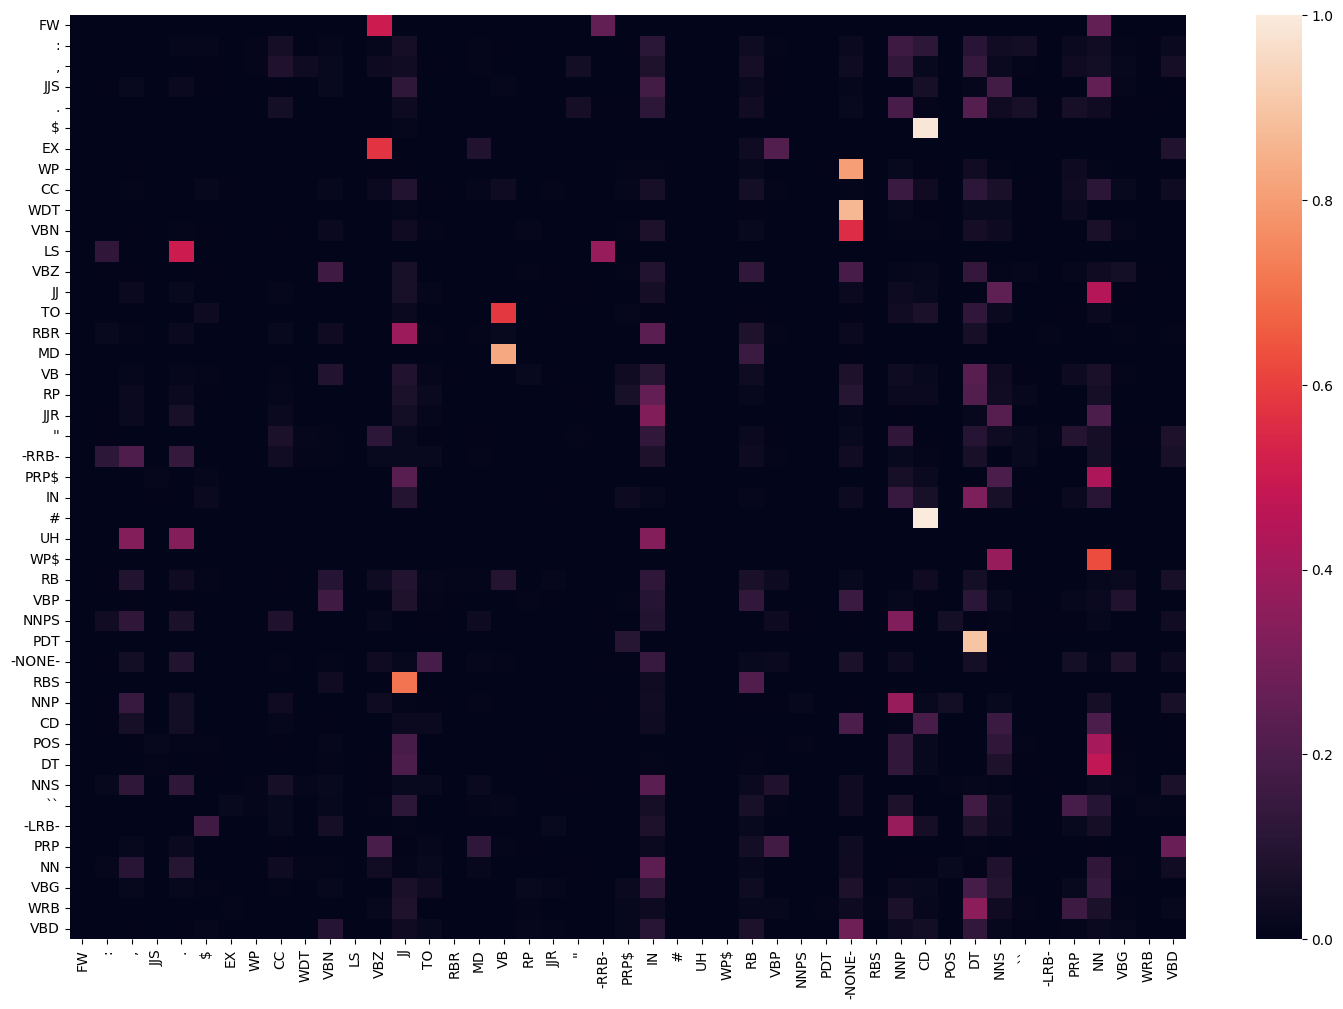

In [90]:
# heatmap of tags matrix

plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()


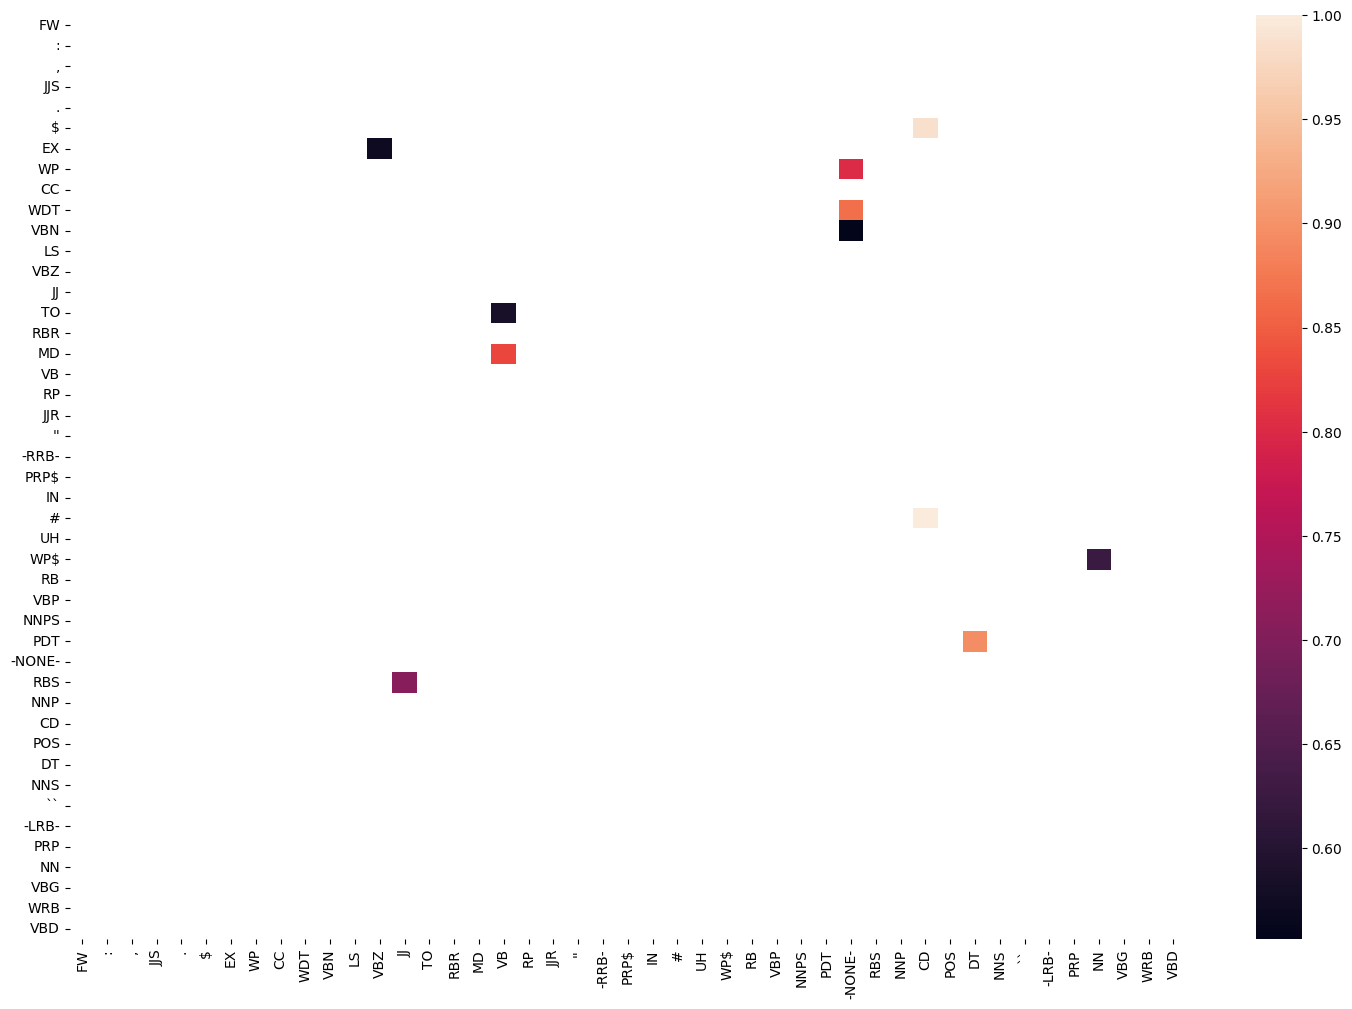

In [91]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

## 3. Viterbi Algorithm

Let's now use the computed probabilities P(word,tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/word)=P(word/tag).P(tag / tag-1) for each tag in the tag set, and then assign the tag having the max P(tag/word).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag-1 of the previous token.

Note: P(tag|start) = P(tag|'.') 

In [92]:
len(train_tagged_words)

70506

In [93]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in tqdm(enumerate(words)):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            prob,count = word_given_tag(words[key],tag)
            emission_p = prob/count
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))



## 4. Evaluating on Test Set

In [108]:
# Running the Viterbi algorithm on a few sample sentences

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
print(f'{test_run[0]}') 
print(f'{test_tagged_words[:5]}')

[('The', 'DT'), ('charges', 'NNS'), ('were', 'VBD'), ('partly', 'RB'), ('offset', 'VBN'), ('*-1', '-NONE-'), ('by', 'IN'), ('a', 'DT'), ('$', '$'), ('2', 'CD'), ('million', 'CD'), ('*U*', '-NONE-'), ('gain', 'NN'), ('on', 'IN'), ('the', 'DT'), ('sale', 'NN'), ('of', 'IN'), ('investments', 'NNS'), ('of', 'IN'), ('two', 'CD'), ('joint', 'JJ'), ('ventures', 'NNS'), (',', ','), ('he', 'PRP'), ('said', 'VBD'), ('0', '-NONE-'), ('*T*-2', '-NONE-'), ('.', '.')]
['The', 'charges', 'were', 'partly', 'offset']


In [109]:
# tagging the test sentences
tagged_seq = Viterbi(test_tagged_words)


126it [00:44,  2.85it/s]


In [110]:
print(tagged_seq)
print(test_run_base)


[('The', 'DT'), ('charges', 'NNS'), ('were', 'VBD'), ('partly', 'RB'), ('offset', 'VBN'), ('*-1', '-NONE-'), ('by', 'IN'), ('a', 'DT'), ('$', '$'), ('2', 'CD'), ('million', 'CD'), ('*U*', '-NONE-'), ('gain', 'VB'), ('on', 'IN'), ('the', 'DT'), ('sale', 'NN'), ('of', 'IN'), ('investments', 'NNS'), ('of', 'IN'), ('two', 'CD'), ('joint', 'JJ'), ('ventures', 'FW'), (',', 'FW'), ('he', 'FW'), ('said', 'FW'), ('0', 'FW'), ('*T*-2', 'FW'), ('.', 'FW'), ('Scientists', 'FW'), ('had', 'FW'), ('obtained', 'FW'), ('even', 'FW'), ('higher', 'FW'), ('current-carrying', 'FW'), ('capacity', 'NN'), ('in', 'IN'), ('thin', 'JJ'), ('films', 'NNS'), ('of', 'IN'), ('the', 'DT'), ('new', 'JJ'), ('superconductors', 'NNS'), (',', ','), ('but', 'CC'), ('have', 'VBP'), ('had', 'VBN'), ('problems', 'NNS'), ('*-2', '-NONE-'), ('increasing', 'VBG'), ('the', 'DT'), ('amount', 'NN'), ('of', 'IN'), ('current', 'JJ'), ('that', 'IN'), ('bulk', 'NN'), ('crystals', 'NNS'), ('could', 'MD'), ('carry', 'VB'), ('*T*-1', '-NON

In [111]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [112]:
accuracy = len(check)/len(tagged_seq)

In [113]:
accuracy

0.7698412698412699

In [124]:
## Testing
sentence_test = 'Twitter is the best networking social site. Man is a social animal. Data science is an emerging field. Data science jobs are high in demand.'
words = word_tokenize(sentence_test)

tagged_seq = Viterbi(words)


29it [00:10,  2.73it/s]


In [125]:
print(tagged_seq)


[('Twitter', 'FW'), ('is', 'VBZ'), ('the', 'DT'), ('best', 'JJS'), ('networking', 'NN'), ('social', 'JJ'), ('site', 'FW'), ('.', 'FW'), ('Man', 'FW'), ('is', 'VBZ'), ('a', 'DT'), ('social', 'JJ'), ('animal', 'FW'), ('.', 'FW'), ('Data', 'FW'), ('science', 'FW'), ('is', 'VBZ'), ('an', 'DT'), ('emerging', 'VBG'), ('field', 'NN'), ('.', '.'), ('Data', 'NNP'), ('science', 'FW'), ('jobs', 'FW'), ('are', 'NN'), ('high', 'JJ'), ('in', 'IN'), ('demand', 'NN'), ('.', '.')]
